In [1]:
import os
import sys
import requests
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
from dataclasses import dataclass, field

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from functions.display import display

In [2]:
year = '2023-01-01'
params = {
    'page[size]': '5000',
    'page[number]': '1',
    'filter': f'record_date:gte:{year}'
}
endpoint = '/v1/accounting/dts/deposits_withdrawals_operating_cash'
base_url = 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service'
url = base_url + endpoint
all_data = []

In [3]:
@dataclass
class Data:
    url: str
    rows: int = 0
    df: pd.DataFrame = None
    last_accessed: datetime = None
    all_data: list = field(default_factory=list)
    params: dict = field(default_factory=dict)
    columns: dict = field(default_factory=dict)
    
    def __post_init__(self):
        """
        Initialize the sub_menu dictionary.
        To add more menu options, create the function and add it to the sub_menu dictionary.
        Follow the format shown below. Use nested dictionaries to create sub menus.
        """
        self.sub_menu = {
            "Back": 'back',
            "Search": self.search,
            "Parameters": {
                "Back": 'back',
                "List parameters": self.list_parameters,
                "Edit parameters": self.edit_parameters
            },
            "Data": {
                "Back": 'back',
                "View all": self.view_data,
                "View size": self.view_data_size,
                "List columns": self.list_columns
            }
        }
    
    def search(self) -> pd.DataFrame:
        """
        Fetches all data from the API by handling pagination (The amount of data returned at one time).
        """
        while True:
            # Make the request to the API
            response = requests.get(self.url, params=self.params)

            # Check if the request was successful
            if response.status_code != 200:
                break

            # Extract the data from the response
            data = response.json().get('data', [])
            
            # If there's no more data, stop fetching
            if not data:
                print("No more data returned. All data fetched.")
                break

            # Add the fetched data to the list
            self.all_data.extend(data)
            print(f"Fetched {len(data)} entries from page {self.params['page[number]']}. Total entries so far: {len(self.all_data)}")

            # Increment the page number for the next request
            self.params['page[number]'] = str(int(self.params['page[number]']) + 1)

        # After fetching all pages, convert the data to a DataFrame
        if self.all_data:
            self.df = pd.DataFrame(self.all_data)
            self.last_accessed = datetime.now()
            for column in self.df.columns:
                self.columns[column.replace('_', ' ').capitalize()] = column
            self.rows = len(self.df)
            print(f"Total rows fetched: {self.df.shape[0]}")
        else:
            print("No data found.")

        return
    
    def list_parameters(self):
        for item in self.params:
            print(item)
    
    def edit_parameters(self, params):
        choice = display(params)
        self.params = params
    
    def list_columns(self):
        for column in self.columns:
            print(column)
    
    def pick_columns(self):
        return display(self.columns)
    
    def view_data_size(self):
        print(f'Total entries in dataset: {self.rows}')
    
    def view_data(self):
        print(self.df.describe())

In [4]:
data = Data(url=url, params=params)
display(data.sub_menu)


Choose an option:
1. Back
2. Search
3. Parameters
4. Data
Fetched 5000 entries from page 1. Total entries so far: 5000
Fetched 5000 entries from page 2. Total entries so far: 10000
Fetched 5000 entries from page 3. Total entries so far: 15000
Fetched 5000 entries from page 4. Total entries so far: 20000
Fetched 5000 entries from page 5. Total entries so far: 25000
Fetched 5000 entries from page 6. Total entries so far: 30000
Fetched 5000 entries from page 7. Total entries so far: 35000
Fetched 5000 entries from page 8. Total entries so far: 40000
Fetched 5000 entries from page 9. Total entries so far: 45000
Fetched 5000 entries from page 10. Total entries so far: 50000
Fetched 5000 entries from page 11. Total entries so far: 55000
Fetched 5000 entries from page 12. Total entries so far: 60000
Fetched 5000 entries from page 13. Total entries so far: 65000
Fetched 5000 entries from page 14. Total entries so far: 70000
Fetched 5000 entries from page 15. Total entries so far: 75000
Fetche

In [5]:
data.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83545 entries, 0 to 83544
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   record_date              83545 non-null  object
 1   account_type             83545 non-null  object
 2   transaction_type         83545 non-null  object
 3   transaction_catg         83545 non-null  object
 4   transaction_catg_desc    83545 non-null  object
 5   transaction_today_amt    83545 non-null  object
 6   transaction_mtd_amt      83545 non-null  object
 7   transaction_fytd_amt     83545 non-null  object
 8   table_nbr                83545 non-null  object
 9   table_nm                 83545 non-null  object
 10  src_line_nbr             83545 non-null  object
 11  record_fiscal_year       83545 non-null  object
 12  record_fiscal_quarter    83545 non-null  object
 13  record_calendar_year     83545 non-null  object
 14  record_calendar_quarter  83545 non-nul

In [6]:
category = data.df['transaction_type'] == 'Withdrawals'
data.df[category].head()

,record_date,account_type,transaction_type,transaction_catg,transaction_catg_desc,transaction_today_amt,transaction_mtd_amt,transaction_fytd_amt,table_nbr,table_nm,src_line_nbr,record_fiscal_year,record_fiscal_quarter,record_calendar_year,record_calendar_quarter,record_calendar_month,record_calendar_day
73,2023-01-03,Treasury General Account (TGA),Withdrawals,Corporation for Public Broadcasting,null,0,0,475,II,Deposits and Withdrawals of Operating Cash,75,2023,2,2023,1,01,03
74,2023-01-03,Treasury General Account (TGA),Withdrawals,Defense Vendor Payments (EFT),null,344,344,105938,II,Deposits and Withdrawals of Operating Cash,76,2023,2,2023,1,01,03
75,2023-01-03,Treasury General Account (TGA),Withdrawals,Dept of Agriculture (USDA) - misc,null,52,52,6398,II,Deposits and Withdrawals of Operating Cash,77,2023,2,2023,1,01,03
76,2023-01-03,Treasury General Account (TGA),Withdrawals,USDA - Child Nutrition,null,124,124,8000,II,Deposits and Withdrawals of Operating Cash,78,2023,2,2023,1,01,03
77,2023-01-03,Treasury General Account (TGA),Withdrawals,USDA - Commodity Credit Corporation,null,44,44,6595,II,Deposits and Withdrawals of Operating Cash,79,2023,2,2023,1,01,03


In [7]:
data.df['record_date'] = pd.to_datetime(data.df['record_date'])
data.df['transaction_today_amt'] = pd.to_numeric(data.df['transaction_today_amt'])
data.df['transaction_fytd_amt'] = pd.to_numeric(data.df['transaction_fytd_amt'])
plot = data.df[['record_date', 'transaction_fytd_amt']].sort_values(by='record_date', ascending=False)

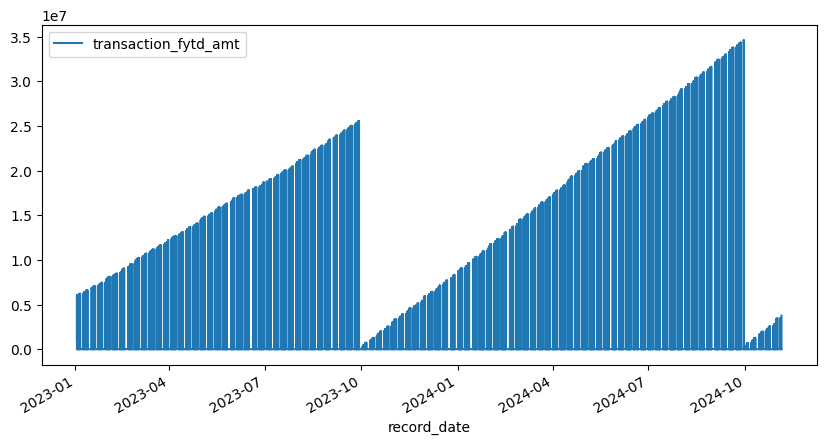

In [8]:

plot.plot(x='record_date', y='transaction_fytd_amt', kind='line', figsize=(10, 5))
plt.show()

In [9]:
data.df.pivot_table(index='account_type', columns='transaction_type', aggfunc='count', values='transaction_today_amt')

transaction_type,Deposits,Withdrawals
account_type,,
Treasury General Account (TGA),35879.0,46738.0
Treasury General Account Total Deposits,464.0,NaN
Treasury General Account Total Withdrawals,NaN,464.0


In [10]:
# df['transaction_today_amt'] = pd.to_numeric(df['transaction_today_amt'])
# df_sorted = df['transaction_today_amt'].sort_values(ascending=False)
# print(df_sorted)